<h1 style="color:maroon"><center> Machine Learning Models for Air Quality Applications </center></h1>

In [1]:
import netCDF4
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import numpy as np
import math
import csv
import os
from tqdm import tqdm_notebook as tqdm
from keras_tqdm import TQDMNotebookCallback
from ipywidgets import interactive
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
# Configuration
analyze = False
save_to_file = False
read_from_file = False
create_plots = True

In [3]:
def get_file_list(data_dir):
    return [os.path.join(data_dir, name) for name in os.listdir(data_dir)]


aq_dir='C:/Users/woshi/Desktop/CE_675_Project/Data/aq_conc/'
emis_dir='C:/Users/woshi/Desktop/CE_675_Project/Data/emis_data/'
met_dir='C:/Users/woshi/Desktop/CE_675_Project/Data/met_data/'

aq_files = get_file_list(aq_dir)
emis_files = get_file_list(emis_dir)
met_files = get_file_list(met_dir)

## Preview interactive plots if analyze == True
- available for notebook package widgets only

In [4]:
def interact(day_of_yr, hr_of_day):
    aq_data = netCDF4.Dataset(aq_files[day_of_yr-1]) # minus one because of referring to indices of the file list
    emis_data = netCDF4.Dataset(emis_files[day_of_yr-1])
    O3 = aq_data.variables['O3'][:]
    NO = emis_data.variables['NO'][:]
    
    plot_aq(O3, NO, day_of_yr, hr_of_day)
    
def plot_aq(aq_data, emis_data, day_of_yr, hr_of_day):
    o3ex = aq_data[hr_of_day-1][0]
    noex = emis_data[hr_of_day-1][0]

    # set canvas
    fig = plt.figure(figsize=(10,10))
    colors = [(0.33,0.33,0.33)] + [(plt.cm.jet(i)) for i in range(1,256)]
    new_map = matplotlib.colors.LinearSegmentedColormap.from_list('new_map', colors, N=64)
    
    # add the first subplot for aq(O3)
    ax = fig.add_subplot(2,1,1)
    i = ax.imshow(1000*o3ex, cmap=new_map, origin='lower',vmin=0, vmax=50, interpolation='bilinear')

    ax.set_title('Day_of_the_year = ' + str(day_of_yr) + "\n" 
                 + 'Hour_of_the_day = ' + str(hr_of_day), fontsize=16)
    ax.set_ylabel('Y_Grid', fontsize=14)
    ax.tick_params('both', labelsize=14)

    cb = fig.colorbar(i, fraction=0.046, pad=0.04)
    cb.set_label(label= 'Ozone concentration/ppb', size=14,)
    cb.ax.tick_params(labelsize=14)
    
    # add the second subplot for emis(NO)
    ax = fig.add_subplot(2,1,2)
    i = ax.imshow(noex, cmap=new_map, origin='lower', vmin=0, vmax=0.1,interpolation='bilinear')
    
    ax.set_xlabel('X_Grid', fontsize=14)
    ax.set_ylabel('Y_Grid', fontsize=14)
    ax.tick_params('both', labelsize=14)

    cb = fig.colorbar(i, fraction=0.046, pad=0.04)
    cb.set_label(label= 'NO emission rate/mol*s-1', size=14,)
    cb.ax.tick_params(labelsize=14)

In [5]:
interactive_plot = interactive(interact, 
                               day_of_yr = widgets.IntSlider(1, 1, len(aq_files)), 
                               hr_of_day = widgets.IntSlider(1, 1, 24))

if analyze:
    display(interactive_plot)

# <h1><center> Generate Training Data from CTM Output </center></h1>
We generate training data from the ouput of CTM models to train a machine learning model. We first select a random points in the domain where we have "observed concentration data". For these points we generate the following training data.
### Emissions
- Surface emissions around the points selected
- Surface emissions over aggregated domain



### Input Data Files For Training

In [4]:
#Input Data
conc_data = netCDF4.MFDataset(aq_files)#concentrations 
o3_data = conc_data['O3']
emis_data = netCDF4.MFDataset(emis_files) #emissions 
met_data = netCDF4.MFDataset(met_files)#Met

#Monitor_Locations
monitors_file = 'C:/Users/woshi/Desktop/CE_675_Project/Data/loc_data/monitor_list_NC.csv'
with open(monitors_file) as csvfile:
    reader = csv.DictReader(csvfile)
    monitor_points = [(int(float(row['Col'])), int(float(row['Row'] ))) for row in reader if row['Col']]

monitors_x, monitors_y = zip(*monitor_points)

In [5]:
o3_obsv = o3_data[:,0,59,119]

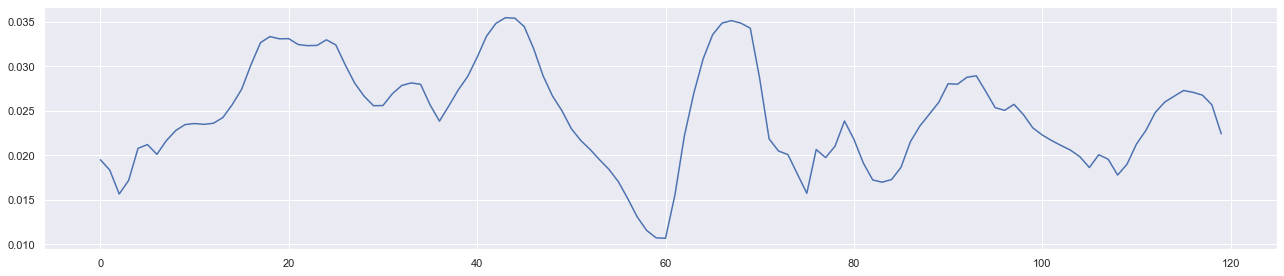

In [6]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_subplot(1,1,1)
# p1 = ax.plot(test_predict_descaled)
p2 = ax.plot(o3_obsv)
fig.tight_layout()

In [7]:
o3_data[4,0,59,119]

0.02075863

### Set the following parameters to generate training matrix.
- t_shift_emis: parameter to incorporate historical emissions data. (no. of hours)
- t_monitors_history: Parameter to incorporate historical observations data (no. of hours)
- emis_species: Chemical species for which emissions are incorporated

In [8]:
training_params = {
                   'd' : 1, #local_emissions_size
                   'emis_species': [ 'NO2'], #emission_species
                   'met_params':['Q2', 'TEMP2', 'WSPD10'], #met parameters
                   'emis_data': emis_data,
                   'met_data':met_data,
                   'conc_data': o3_data,
                   'monitor_points':monitor_points
                 }
## Random points for testing/performance evaluation
np.random.seed(1977)
num_points = 300

#No. of periods in each training sequence
sequence_size = 24

### Generate random points in the domain for training and testing. Bias towards sampling more near Atlanta

In [9]:
def get_random_domain_points(num_points, domain_params):
    x_points = np.random.normal(domain_params['x_center'], 
                                domain_params['x_std'],
                                num_points)
    
    y_points = np.random.normal(domain_params['y_center'], 
                                domain_params['y_std'],
                               num_points)

    def threshold_points(x,maxx,minn):
        return x[(x<maxx) & (x>minn)]

    x_p = map(int,threshold_points(x_points,domain_params['x_max'], domain_params['x_min']))
    y_p = map(int,threshold_points(y_points,domain_params['y_max'], domain_params['y_min']))
    return list(set(zip(x_p, y_p)))
    


domain_params = {
    'x_center': 65, 'x_std' : 15, 'x_max': 180, 'x_min' : 0,
    'y_center' : 125,'y_std' : 15,'y_max': 180, 'y_min':0    
}

if not read_from_file:
    print('Generating random points for training and testing')
    pxy = get_random_domain_points(num_points,domain_params)

Generating random points for training and testing


### Assemble the feature matrix
- Returns distance and angle for an arbitrary point in the domain
    w.r.t. monitor network. These are w.r.t. each monitor or centroid of all monitors
    
    - **Args**:
        x: x_cooridate of arbitrary point
        y: y_coordinate of arbitrary point
        training_params: Training parameters containing locations of monitors
        centroid: if True, returns distance and angle from the centrod of the monitors
    
    - **Returns**:
        Angles and distances
    
    - **Unit verctor**:
        Returns the unit vector of the vector.
        
    - **angle between**:
        Returns the angle in radians between vectors 'v1' and 'v2'
 
    - Define **emis**, **monitors** and **met** predictors
    
    - **get predictors xyt**: For each point and timestamp(s) generate a row of predictors
    
    - Define **getXy**

In [12]:
def dist_predictors(x,y, monitor_points,centroid=True,**kwargs):
    
    x_centroid = np.average([point[0] for point in monitor_points])
    y_centroid = np.average([point[1] for point in monitor_points])
   
    def unit_vector(vector):
        return vector / np.linalg.norm(vector)

    def angle_between(v1, v2):
        v1_u = unit_vector(v1)
        v2_u = unit_vector(v2)
        return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    if centroid:   
        distance = math.sqrt((x_centroid - x)**2 + (y_centroid -y)**2)
        v1 = (x_centroid, y_centroid)
        v2 = (x,y)
        angle = angle_between(v1,v2)
        return np.array([distance, angle])
    else:
        
        distances =[math.sqrt((x - point[0])**2 + (y - point[1])**2) for point in monitor_points]
        angles = [angle_between((x,y), (point[0], point[1])) for point in monitor_points]
        da = distances + angles
        return np.array(da) 

In [13]:
def emis_predictors(x,y,tlist, d, emis_data, emis_species, **kwargs):

    xs = np.arange(-d,d+1) + x
    ys = np.arange(-d,d+1) + y
    num_cells = len(xs)*len(ys)

    dummy = np.arange(1)
    grid = np.ix_(tlist,dummy,xs,ys)
    
    def get_emis_slice(emis_data,species):
        e1 = emis_data[species][:]
        e2 = e1[grid]
        return e2.reshape(len(tlist), num_cells)

    emis_seq = [ get_emis_slice(emis_data, species) for species in emis_species] 
    return np.concatenate(emis_seq,axis=1)    

def history_monitors_predictors(t,conc_data, monitor_points, **kwargs):

    monitors_x, monitors_y = zip(*monitor_points) 
    concs = conc_data[t][:,0,monitors_x,monitors_y]

    return concs

def met_predictors(t,monitor_points, met_data, met_params, **kwargs):
   
    monitors_x, monitors_y = zip(*monitor_points) 
    
    met_seq = []
    for param in met_params:
        m1 = met_data[param][:]
        m2 = m1[t][:,0,monitors_x,monitors_y]
        #print(m2)
        #print(m2.shape)
        met_seq.append(m2)
    return np.concatenate(met_seq, axis=1)

In [14]:
def get_predictors_xyt(p,tlist,training_params,debug=False):
    
    x = p[0]
    y = p[1]

    dist = dist_predictors(x,y,**training_params) #time invariant
    dist_tile = np.tile(dist,(len(tlist),1))

    emis = emis_predictors(x,y,tlist,**training_params)
    met  = met_predictors(tlist,**training_params)
    hist = history_monitors_predictors(tlist,**training_params)
    
    try:
        preds = np.concatenate([dist_tile, emis, hist,met], axis=1)
        return preds
    except:
        return [dist_tile,emis,hist,met]

def get_Xy(pxy, hour_begin_seq, training_params):
    from itertools import product, repeat

    predictors = {}
    aq = {}
    conc_data =training_params['conc_data']
    pxy_time = [i for i in product(pxy,hour_begin_seq)]
    for pt in tqdm(pxy_time, desc='Seq Processed'):
        point = pt[0]
        hour_begin = pt[1]
        tlist = [i for i in range(hour_begin - sequence_size, hour_begin)]
        predictors[pt] = get_predictors_xyt(point,tlist,training_params,debug=False)
        
        hour_next = hour_begin + 1
        aq[pt] = conc_data[hour_next, 0, point[0], point[1]]
    
    return predictors, aq

In [25]:
hour_begin_seq = [0,6]

if not read_from_file:
    predictors, aq = get_Xy(pxy, hour_begin_seq,training_params)    
    print ('\n Done getting predictors')

<ipython-input-14-37d2517c603a>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pt in tqdm(pxy_time, desc='Seq Processed'):




 Done getting predictors


In [27]:
predictors[((59, 119),0)][2]

171

### Create Random Split for Training and Testing
- **get splits**: Random sample for training

In [16]:
def get_splits(predictors,train_fraction=0.95):
    num_predictors = len(predictors)
    pxy = list(predictors.keys())

    num_train = int(train_fraction*num_predictors)
    train_indices = np.random.choice(np.arange(num_predictors),num_train, replace=False)
    pxy_train = [pxy[i] for i in train_indices]
    predictors_train = [predictors[i] for i in pxy_train]
    aq_train = [aq[i] for i in pxy_train]
    print ('number of training points', num_train, '&', len(predictors_train))

    #Random sample for Testing
    predictors_test = [predictors[i] for i in pxy if i not in pxy_train]
    aq_test = [aq[i] for i in pxy if i not in pxy_train]
    pxy_test = [i for i in pxy if i not in pxy_train]
    print('number of testing points', len(predictors_test), '&', len(aq_test))
    return predictors_train, aq_train, predictors_test, aq_test

if not read_from_file:
    print('Getting train and test splits')
    predictors_train, aq_train, predictors_test, aq_test = get_splits(predictors)

Getting train and test splits
number of training points 4959 & 4959
number of testing points 261 & 261


In [20]:
# predictors_train

In [21]:
len(aq_train)

4959

In [22]:
# if create_plots:
#     fig = plt.figure(figsize=(8,8))
#     ax = fig.add_subplot(1,1,1)
#     pxy_train = list(predictors_train.keys())
#     pxy_test = list(predictors_test.keys())
#     points_train = ax.scatter([x[0] for x in pxy_train], [x[1] for x in pxy_train], 
#                               s=30, marker='o', color ='lightblue', label='Train')
#     points_test = ax.scatter([x[0] for x in pxy_test], [x[1] for x in pxy_test],
#                              s=30, marker='o', color='lightcoral', label='Test')
#     points = ax.scatter(monitors_x, monitors_y, color='black', marker='*', s=30, label='Monitor')
#     ax.set_ylim([0,180])
#     ax.set_xlim([0,180])
#     ax.set_xlabel('X_Grid', fontsize=12)
#     ax.set_ylabel('Y_Grid', fontsize=12)
#     ax.tick_params('both', labelsize=12)
#     ax.legend(fontsize='x-large')
#     fig.savefig('C:/Users/woshi/Desktop/CE_675_Project/4b.pdf', format='pdf', dpi=1200)

### Data Standerdization

In [17]:
if not read_from_file:

    print('scaling inputs and outputs')
    from sklearn.preprocessing import MinMaxScaler

    data = np.concatenate(list(predictors.values()))
    pred_scaler = MinMaxScaler()
    pred_scaler.fit(data)

    aq_data = np.stack(aq.values()).reshape(-1,1)
    aq_scaler = MinMaxScaler()
    aq_scaler.fit(aq_data)

    predictors_train_scaled = [pred_scaler.transform(mx) for mx in predictors_train]
    predictors_train_rnn = np.stack(predictors_train_scaled)
    aq_train_rnn = aq_scaler.transform(np.stack(aq_train).reshape(-1,1))

    predictors_test_scaled = [pred_scaler.transform(mx) for mx in predictors_test]
    predictors_test_rnn = np.stack(predictors_test_scaled)
    aq_test_rnn = aq_scaler.transform(np.stack(aq_test).reshape(-1,1))

### Save for future use.
predictors_file = 'C:/Users/woshi/Desktop/CE_675_Project/Data/saved_data/'

if save_to_file == True:
    #data_to_save = [predictors_train_rnn, aq_train, predictors_test_rnn,aq_test] 

    np.savez(predictors_file, predictors_train_rnn = predictors_train_rnn, #X_train, shape=(samples,tsteps,features)
                              aq_train_rnn = aq_train_rnn, #y_train
                              predictors_test_rnn = predictors_test_rnn, #X_test
                              aq_test_rnn = aq_test_rnn #y_test
            )

scaling inputs and outputs


C:\Users\woshi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [18]:
# predictors_test_rnn.shape

In [19]:
# predictors_test_rnn

## Modeling

In [20]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM
from keras.utils import np_utils
import copy

In [21]:
s0,s1,s2=predictors_train_rnn.shape
print ('shape of x_train data', s0,s1,s2)
print ('shape of y_train data', aq_train_rnn.shape)

shape of x_train data 4959 24 171
shape of y_train data (4959, 1)


In [22]:
# Design Network
m = Sequential()
m.add(LSTM(128,input_shape=predictors_train_rnn.shape[1:], return_sequences=True, activation='tanh'))
m.add(LSTM(128, activation='tanh'))
m.add(Dropout(0.50))
m.add(Dense(128, activation='tanh'))
m.add(Dense(1))
m.compile(loss='mean_squared_error',optimizer='adam')

In [27]:
# from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
# import eli5
# from eli5.sklearn import PermutationImportance

# my_model = KerasRegressor(build_fn=m)
# perm = PermutationImportance(my_model, random_state=1).fit(predictors_train_rnn, aq_train_rnn, epochs=150, 
#                     validation_data=(predictors_test_rnn, aq_test_rnn), verbose=2, shuffle=True
#                )
# eli5.show_weights(perm, feature_names = X.columns.tolist())

In [28]:
nns_dir='C:/Users/woshi/Desktop/CE_675_Project/Data/models/'
model_json = m.to_json()
with open(nns_dir+"model"+str(128)+str(predictors_train_rnn.shape[1:])+str(0.05)+'adam'+".json", "w") as json_file:
    json_file.write(model_json)
m.save_weights(nns_dir+"model"+str(128)+str(predictors_train_rnn.shape[1:])+str(0.05)+'adam'+".h5")
print("Saved model to disk")

Saved model to disk


In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
# load json and create model
json_file = open('C:/Users/woshi/Desktop/CE_675_Project/Data/models/model128(24, 283)0.05adam.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("C:/Users/woshi/Desktop/CE_675_Project/Data/models/model128(24, 283)0.05adam.h5")
print("Loaded model from disk")

Loaded model from disk


In [2]:
# print(loaded_model.summary())
# print("Inputs: {}".format(loaded_model.input_shape))
# print( "Outputs: {}".format(loaded_model.output_shape))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 128)           210944    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 359,169
Trainable params: 359,169
Non-trainable params: 0
_________________________________________________________________
None
Inputs: (None, 24, 283)
Outputs: (None, 1)


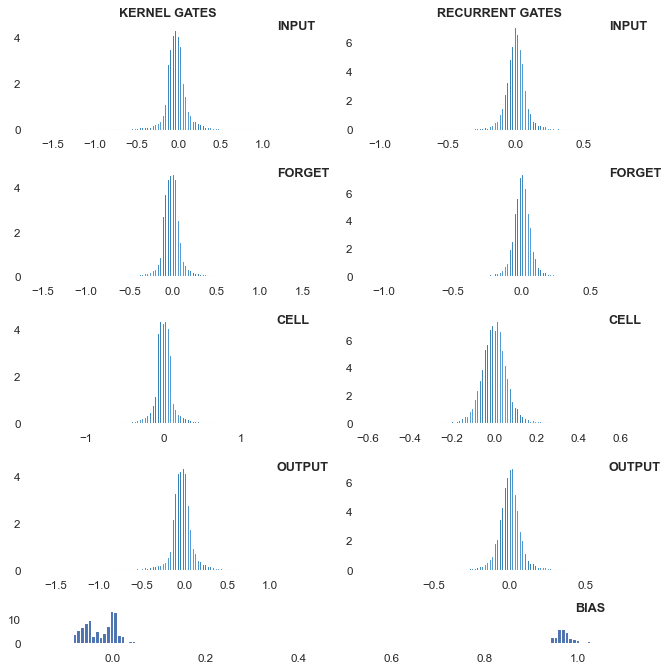

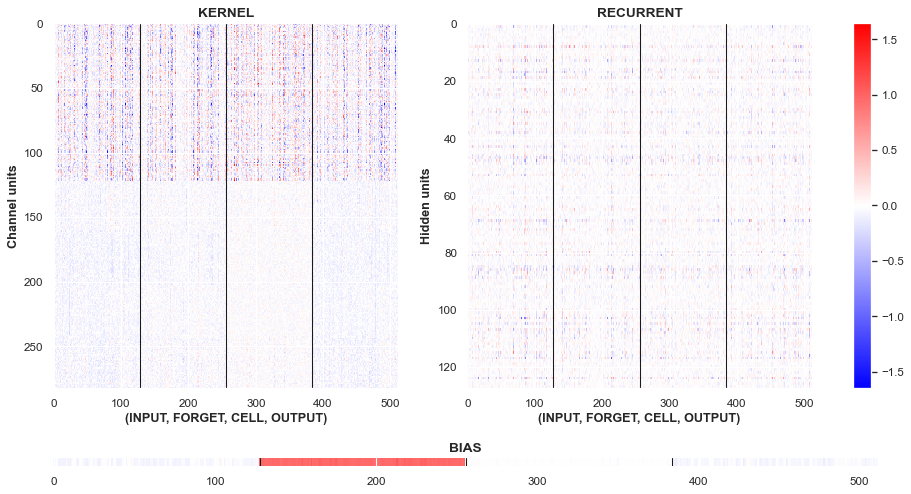

([<Figure size 1064x608 with 4 Axes>],
 [array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000249EC99A250>,
        dtype=object)])

In [35]:
import see_rnn
see_rnn.rnn_histogram(loaded_model, 'lstm', equate_axes=True)
see_rnn.rnn_heatmap(loaded_model, 'lstm')

In [25]:
print(m.summary())
print("Inputs: {}".format(m.input_shape))
print( "Outputs: {}".format(m.output_shape))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 128)           153600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 301,825
Trainable params: 301,825
Non-trainable params: 0
_________________________________________________________________
None
Inputs: (None, 24, 171)
Outputs: (None, 1)


In [33]:
loaded_model.compile('adam', 'mean_squared_error')
history = loaded_model.fit(predictors_train_rnn, aq_train_rnn, epochs=50, 
                    validation_data=(predictors_test_rnn, aq_test_rnn), verbose=2, shuffle=True
               )

In [34]:
history = m.fit(predictors_train_rnn, aq_train_rnn, epochs=150, 
                    validation_data=(predictors_test_rnn, aq_test_rnn), verbose=2, shuffle=True
               )

Epoch 1/150
155/155 - 6s - loss: 0.0391 - val_loss: 0.0149
Epoch 2/150
155/155 - 5s - loss: 0.0162 - val_loss: 0.0149
Epoch 3/150
155/155 - 5s - loss: 0.0145 - val_loss: 0.0124
Epoch 4/150
155/155 - 5s - loss: 0.0134 - val_loss: 0.0131
Epoch 5/150
155/155 - 5s - loss: 0.0130 - val_loss: 0.0131
Epoch 6/150
155/155 - 5s - loss: 0.0129 - val_loss: 0.0122
Epoch 7/150
155/155 - 5s - loss: 0.0127 - val_loss: 0.0129
Epoch 8/150
155/155 - 5s - loss: 0.0125 - val_loss: 0.0130
Epoch 9/150
155/155 - 5s - loss: 0.0123 - val_loss: 0.0122
Epoch 10/150
155/155 - 5s - loss: 0.0125 - val_loss: 0.0120
Epoch 11/150
155/155 - 5s - loss: 0.0123 - val_loss: 0.0122
Epoch 12/150
155/155 - 4s - loss: 0.0123 - val_loss: 0.0135
Epoch 13/150
155/155 - 4s - loss: 0.0124 - val_loss: 0.0120
Epoch 14/150
155/155 - 4s - loss: 0.0123 - val_loss: 0.0123
Epoch 15/150
155/155 - 4s - loss: 0.0125 - val_loss: 0.0126
Epoch 16/150
155/155 - 4s - loss: 0.0122 - val_loss: 0.0119
Epoch 17/150
155/155 - 4s - loss: 0.0120 - val_lo

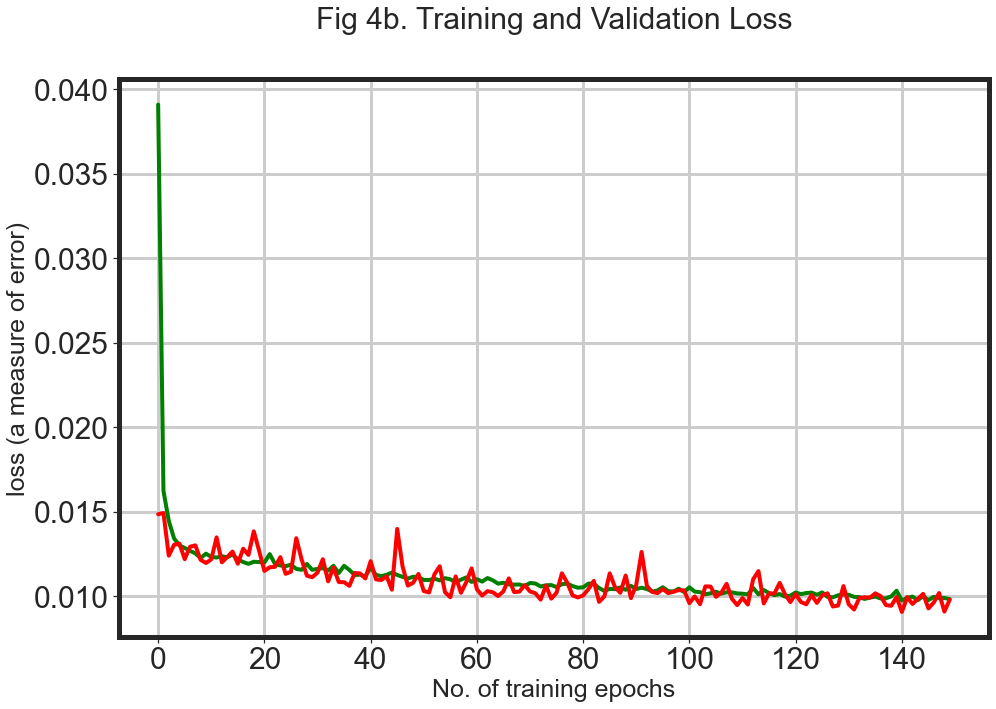

In [36]:
sns.set_style('ticks')
plt.rcParams['axes.linewidth'] = 5

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(1,1,1)
p1 = ax.plot(history.history['loss'], linewidth=4, color ='green')
p2 = ax.plot(history.history['val_loss'], linewidth=4, color ='red')

ax.set_ylabel('loss (a measure of error)', fontdict={'fontsize':25})
ax.set_xlabel('No. of training epochs', fontdict={'fontsize':25})
ax.set_title('Fig 4b. Training and Validation Loss', fontdict={'fontsize':30}, y=1.08)
ax.tick_params(axis='both', labelsize=30)
ax.grid(axis='both', linewidth=3)
# ax.legend((l2, l4), ('oscillatory', 'damped'), loc='upper right', shadow=True)
fig.tight_layout()
fig.savefig('C:/Users/woshi/Desktop/CE_675_Project/4b.pdf', format='pdf', dpi=1200)

In [37]:
test_predict = m.predict(predictors_test_rnn)

test_predict_descaled = aq_scaler.inverse_transform(test_predict)
aq_test_rnn_descaled = aq_scaler.inverse_transform(aq_test_rnn)

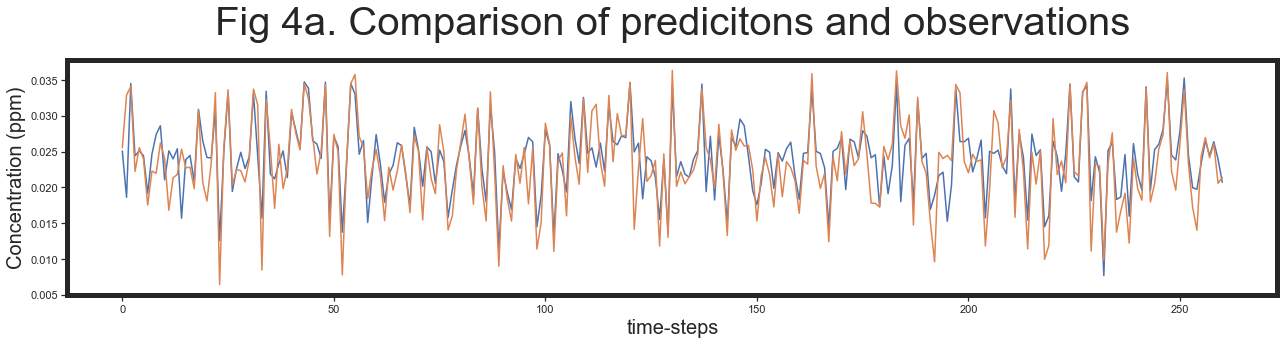

In [38]:
fig2 = plt.figure(figsize=(18,5))
bx = fig2.add_subplot(1,1,1)
p1 = bx.plot(test_predict_descaled)
p2 = bx.plot(aq_test_rnn_descaled)
bx.set_title('Fig 4a. Comparison of predicitons and observations', fontdict={'fontsize':40}, y=1.08)
bx.set_ylabel('Concentration (ppm)', fontdict={'fontsize':20})
bx.set_xlabel('time-steps', fontdict={'fontsize':20})
fig2.tight_layout()
fig2.savefig('C:/Users/woshi/Desktop/CE_675_Project/5a.pdf', format='pdf', dpi=1200)

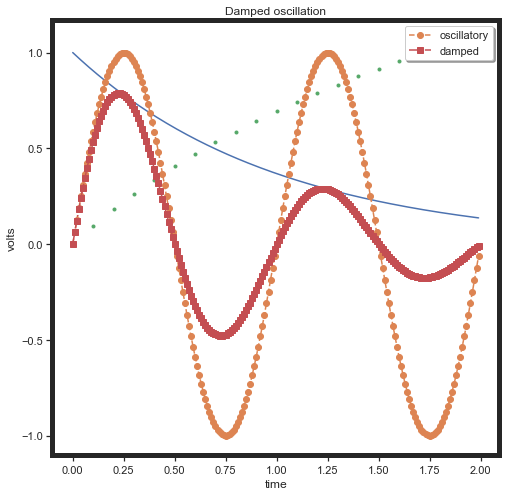

In [39]:
import matplotlib.pyplot as plt
import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D
import numpy as np

t1 = np.arange(0.0, 2.0, 0.1)
t2 = np.arange(0.0, 2.0, 0.01)

fig, ax = plt.subplots(figsize=(8,8))

# note that plot returns a list of lines.  The "l1, = plot" usage
# extracts the first element of the list into l1 using tuple
# unpacking.  So l1 is a Line2D instance, not a sequence of lines
l1, = ax.plot(t2, np.exp(-t2))
l2, l3 = ax.plot(t2, np.sin(2 * np.pi * t2), '--o', t1, np.log(1 + t1), '.')
l4, = ax.plot(t2, np.exp(-t2) * np.sin(2 * np.pi * t2), 's-.')

ax.legend((l2, l4), ('oscillatory', 'damped'), loc='upper right', shadow=True)
ax.set_xlabel('time')
ax.set_ylabel('volts')
ax.set_title('Damped oscillation')
plt.show()

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mae = mean_absolute_error(test_predict_descaled, aq_test_rnn_descaled)
print('MAE is {:.2} PPM'.format(mae))

mse = mean_squared_error(test_predict_descaled, aq_test_rnn_descaled)
#print('MSE is {} PPM'.format(mse))

rmse = np.sqrt(mse)
print('RMSE is {:.2} PPM'.format(rmse))

print('Percent of RMSE to Mean AQ {:.1%}'.format(rmse/aq_test_rnn_descaled.mean()))

MAE is 0.0024 PPM
RMSE is 0.0033 PPM
Percent of RMSE to Mean AQ 14.3%


<ipython-input-41-95ae76142f9c>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


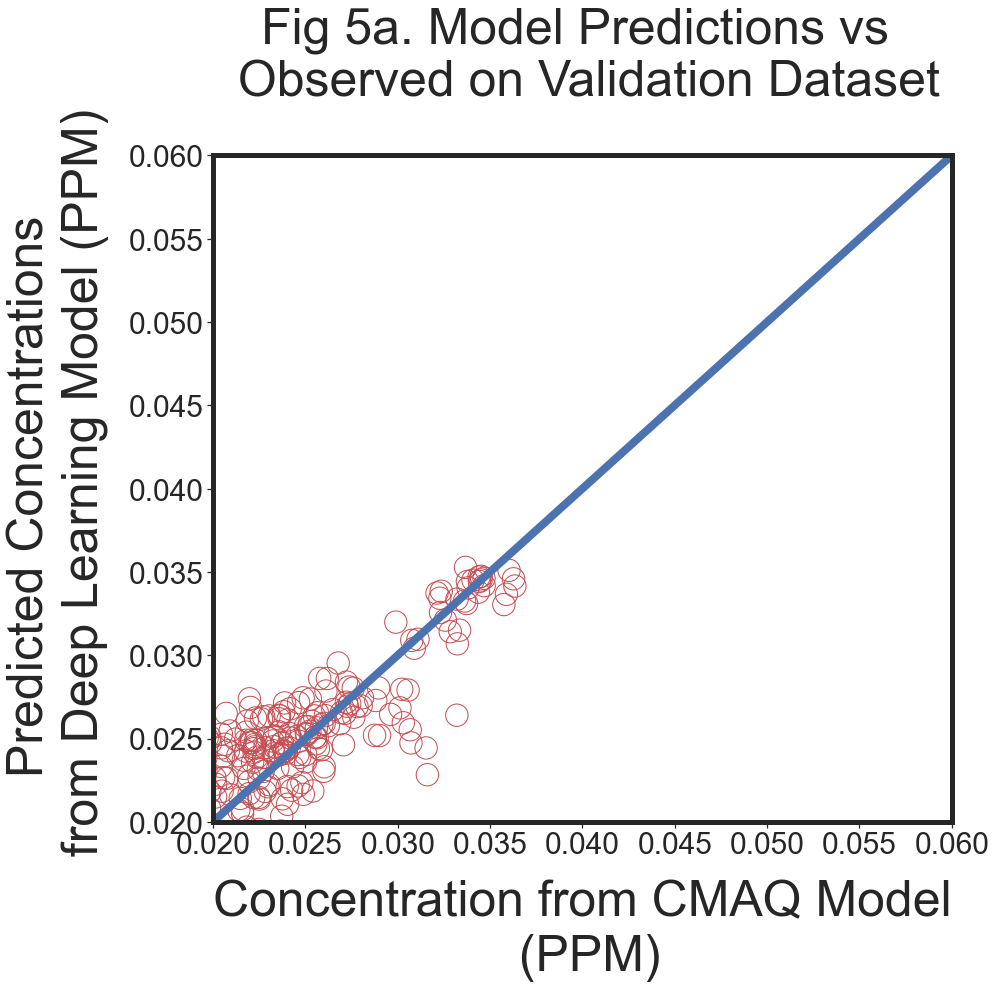

In [41]:
fig = plt.figure(figsize=(14,14))
plt.rcParams['axes.linewidth'] = 5
ax = fig.add_subplot(1,1,1)
p1 = ax.scatter(aq_test_rnn_descaled, test_predict_descaled, edgecolors='r', facecolor="none", s=500, linewidths=1)
ax.set_xlim([0.02,0.06])
ax.set_ylim([0.02,0.06])
ax.set_ylabel('Predicted Concentrations \n from Deep Learning Model (PPM)', fontdict={'fontsize':50}, labelpad=20)
ax.set_xlabel('Concentration from CMAQ Model\n (PPM)', fontdict={'fontsize':50}, labelpad=20)
ax.set_title('Fig 5a. Model Predictions vs \n Observed on Validation Dataset', fontdict={'fontsize':50},y=1.08)

ax.plot([0.01,0.09], [0.01,0.09], linewidth=8)
ax.tick_params(axis='both', labelsize=30)
fig.tight_layout()
fig.show()
fig.savefig('C:/Users/woshi/Desktop/CE_675_Project/5a.pdf', format='pdf', dpi=1200)

### Testing Using Future Days Data

In [42]:
pxy_future = pxy = get_random_domain_points(50,domain_params)
hour_begin_seq = [66,72,78,84]
    
if not read_from_file:
    predictors_future, aq_future = get_Xy(pxy, hour_begin_seq, training_params)    
    print ('\n Done getting predictors')

<ipython-input-15-37d2517c603a>:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for pt in tqdm(pxy_time, desc='Seq Processed'):




 Done getting predictors


In [43]:
## Scale, Predict, and Descale:
def get_model_predictions(model, X_as_dict, X_scaler, y_scaler):
    
    X = list(X_as_dict.values())
    X_temp = [X_scaler.transform(mx) for mx in X]
    X_scaled = np.stack(X_temp)
    y_scaled = model.predict(X_scaled)
    return y_scaler.inverse_transform(y_scaled)

In [44]:
y_model_predicted = get_model_predictions(m, predictors_future, pred_scaler, aq_scaler)
y = np.stack(aq_future.values()).reshape(-1,1)

C:\Users\woshi\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


<ipython-input-45-4da9c41ec5d8>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


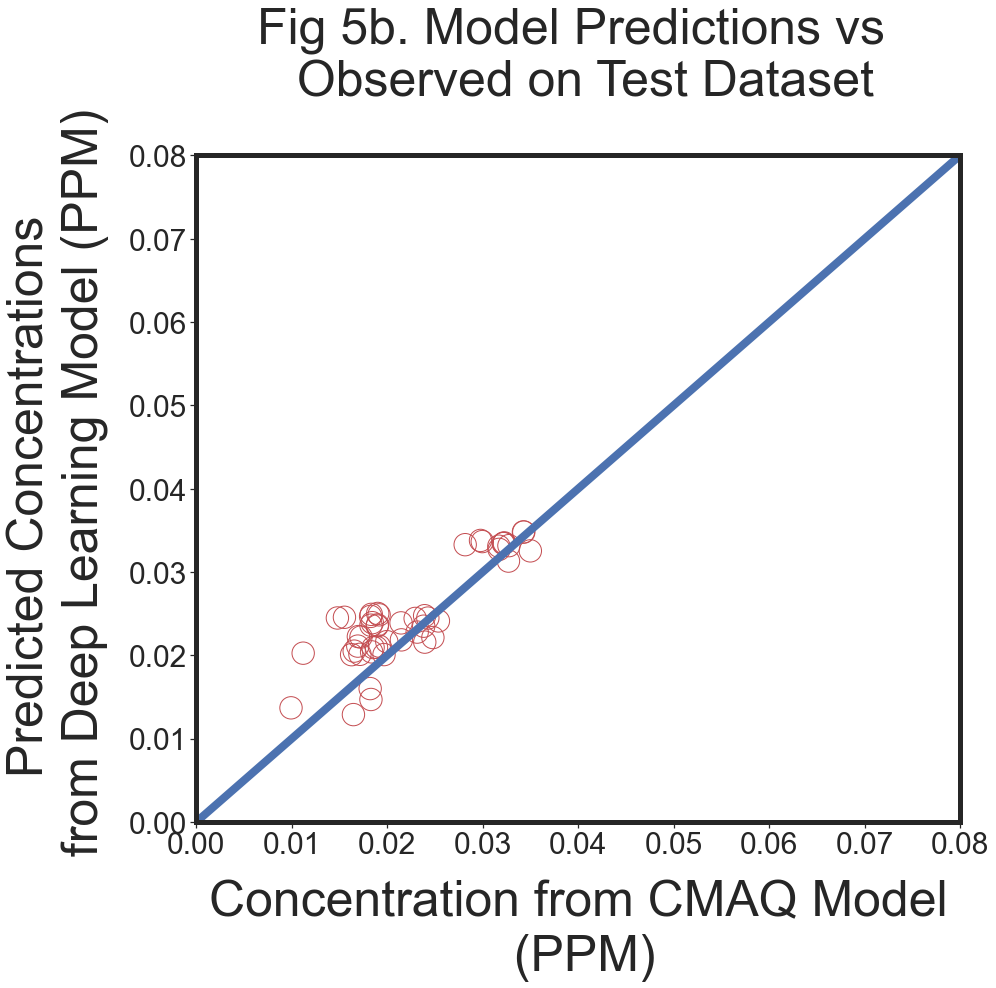

In [45]:
fig = plt.figure(figsize=(14,14))
plt.rcParams['axes.linewidth'] = 5
ax = fig.add_subplot(1,1,1)
p1 = ax.scatter(y[0:50], y_model_predicted[0:50], edgecolors='r', facecolor="none", s= 500, linewidths=1)
ax.set_xlim([0.00,0.08])
ax.set_ylim([0.00,0.08])
ax.set_ylabel('Predicted Concentrations \n from Deep Learning Model (PPM)', fontdict={'fontsize':50}, labelpad=20)
ax.set_xlabel('Concentration from CMAQ Model\n (PPM)', fontdict={'fontsize':50}, labelpad=20)
ax.set_title('Fig 5b. Model Predictions vs \n Observed on Test Dataset', fontdict={'fontsize':50},y=1.08)

ax.plot([0.00,0.09], [0.00,0.09], linewidth=8)
ax.tick_params(axis='both', labelsize=30)
fig.tight_layout()
fig.show()
fig.savefig('C:/Users/woshi/Desktop/CE_675_Project/5b.pdf', format='pdf', dpi=1200)

In [46]:
np.sqrt(mean_squared_error(y, y_model_predicted))

0.004262408

In [ ]:
from keras_sequential_ascii import keras2ascii

keras2ascii(m)

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(
    m,
#     to_file="model.png",
    show_shapes=False,
#     show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
fig2 = plt.figure(figsize=(14,14))
bx = fig2.add_subplot(1,1,1)
p1 = bx.plot(history.history['loss'], linewidth=8)